# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [440]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

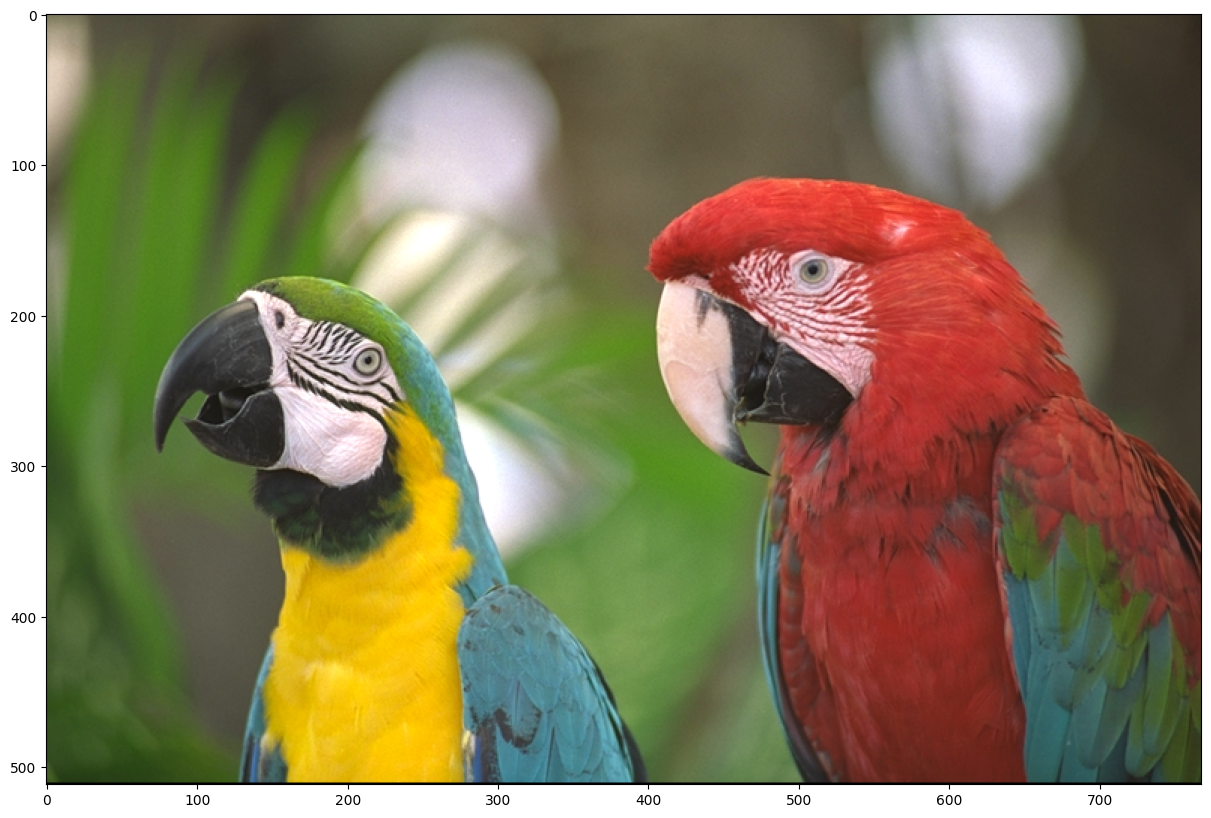

In [441]:
# Load image
img = cv2.imread('../data/kodim23.png')
# img = cv2.imread('../data/white-black.png')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [442]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

def make_float_n_colors_pallete(n):   
    N=n-1
    return [ [i/N,i/N,i/N] for i in range(0,n) ]

float_colors =  np.array(make_float_n_colors_pallete(4))
# colors = (float_colors*255).astype(np.uint8)

print("float_colors =\n",float_colors)



float_colors =
 [[0.         0.         0.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.66666667 0.66666667 0.66666667]
 [1.         1.         1.        ]]


Using the colour pallette, let's quantize the original image.

In [443]:
def find_closest_palette_color(float_pixel,float_colors):
    distances = [np.linalg.norm(float_pixel-color) for color in float_colors]
    error = min(distances)        
    index = distances.index(error)
    return float_colors[index], error


def palette_image(img, float_colors):
    # Cast the image to float
    img_float = img.astype(np.float32)  / 255.0
    # Plot the float image
    # Prepare for quantization
    rows, cols, channels = img.shape
    quantized = np.zeros_like(img_float)
    print("float colors =\n",float_colors)
  
    total_error = 0
    # Apply quantization
    for r in range(rows):
        for c in range(cols):
            # Extract the original pixel value
            pixel = img_float[r,c]
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here OR USE FUNCTIONS 8))))
            new_pixel, error = find_closest_palette_color(pixel,float_colors) 
            # Apply quantization
            quantized[r, c, :] = new_pixel
            total_error += error
    img_int = (quantized * 255).astype(np.uint8)
    return img_int, total_error

print(find_closest_palette_color([1.,1.,1.],float_colors))

img_int, total_error = palette_image(img, float_colors)

(array([1., 1., 1.]), 0.0)
float colors =
 [[0.         0.         0.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.66666667 0.66666667 0.66666667]
 [1.         1.         1.        ]]


[170 170 170] [162 154 126]


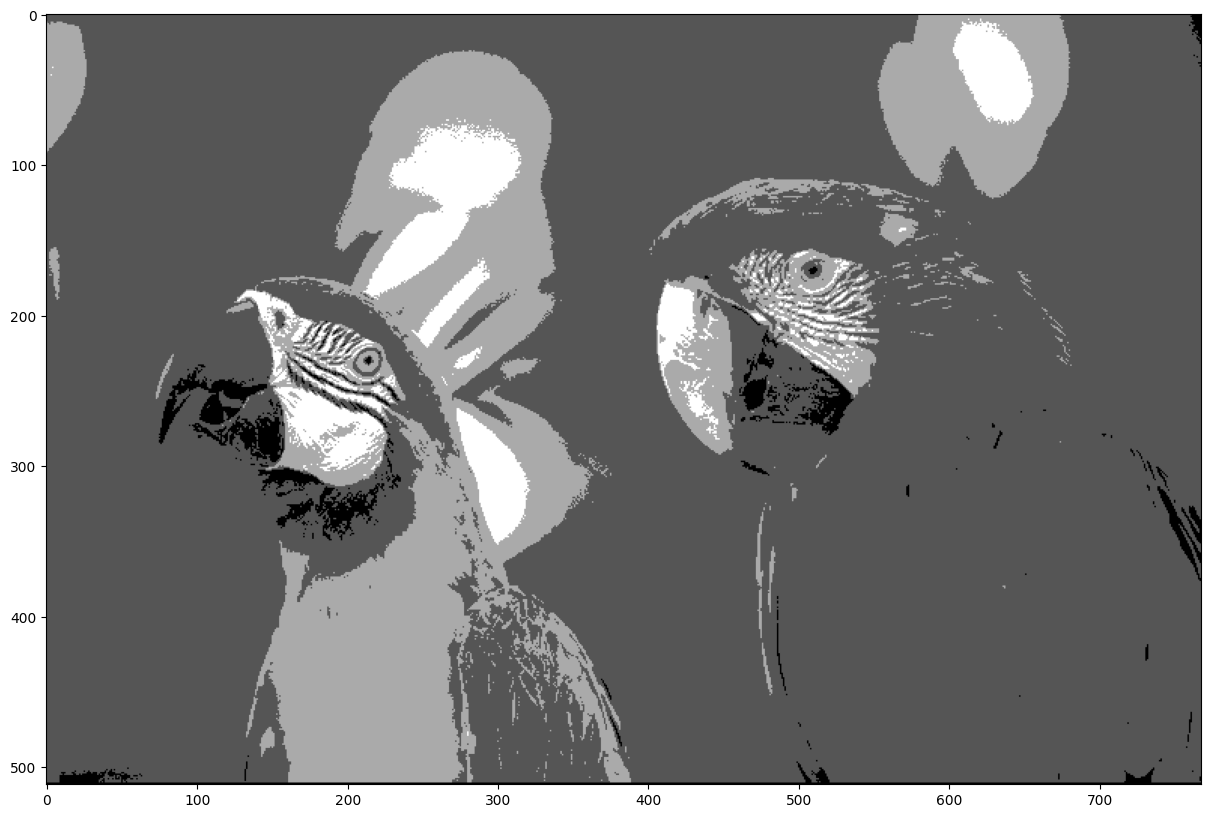

In [444]:
# Show quantized image (don't forget to cast back to uint8)
plt.imshow(img_int)
print(img_int[10,10],img[10,10])

In [445]:
# Compute average quantization error

MSE = np.linalg.norm(total_error) / (rows * cols)
PSNR = 10*np.log10(255*255/MSE)
#print(total_error, avg_error)

avg_quant_error = PSNR = cv2.PSNR(img,img_int)
print("MSE =",MSE, "PSNR =",PSNR,  "cv2.PSNR(img_int,img) =",cv2.PSNR(img_int,img), "cv2.PSNR(img,img) =",cv2.PSNR(img,img))
print("361 dB its infinity for cv2 10**36.1")

MSE = 0.2410334274147269 PSNR = 15.782688699974148 cv2.PSNR(img_int,img) = 15.782688699974148 cv2.PSNR(img,img) = 361.20199909921956
361 dB its infinity for cv2 10**36.1


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [446]:
# Make a temporal copy of the original image, we will need it for error diffusion
def find_closest_pixel(pixel,colors=float_colors):
    distances = [np.linalg.norm(pixel-color) for color in float_colors]
    error = min(distances)        
    index = distances.index(error)
    color = colors[index]     
    return color, pixel-color

def average_error(img1,img2):
    row,col,_=img1.shape
    img1_float = img1.astype(np.float32)
    img2_float = img2.astype(np.float32)
    diff = img1 - img2
    total_error = 0
    for y in range(row):
        for x in range(col):
            total_error += np.linalg.norm(diff[y,x])
            # total_error += diff[y,x]
    return total_error/row/col

def floyd_steinberg_dithering(original_img,float_colors):
    img = np.copy(original_img)
    dithering = np.zeros_like(img).astype(np.float32)
    
    img = img.astype(np.float32) / 255.0
    rows, cols, _ = img.shape

    # Define the error diffusion matrix
    error_diffusion = np.array([
        [0, 0, 7],
        [3, 5, 1]
    ]) / 16.0
    
    for y in range(rows-1):
        for x in range(cols-1):
            # Extract the original pixel value
            old_pixel = img[y, x]
            # Find the closest colour from the pallette (using absolute value/Euclidean distance) 
            # Compute quantization error
            # Note: You may need more than one line of code here 
            new_pixel, quant_error = find_closest_pixel(old_pixel,float_colors)
            img[y, x] = new_pixel            

            # Diffuse the quantization error accroding to the FS diffusion matrix
            # Note: You may need more than one line of code here
            
            for dy in range(2):
                for dx in range(3):
                    ny = y + dy
                    nx = x + dx - 1
                    # if 0 <= ny < rows and 0 <= nx < cols:
                    img[ny, nx] += quant_error * error_diffusion[dy, dx]

            
            # Apply dithering
            dithering[y, x] = new_pixel
    return ( dithering * 255).astype(np.uint8)
    
float_colors = make_float_n_colors_pallete(2)
print(float_colors, len(float_colors))
img_int, _ =  palette_image(img, float_colors)
dithering = floyd_steinberg_dithering(img, float_colors)

[[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]] 2
float colors =
 [[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]]


(<Axes: >, <matplotlib.image.AxesImage at 0x1d8e6dc6390>)

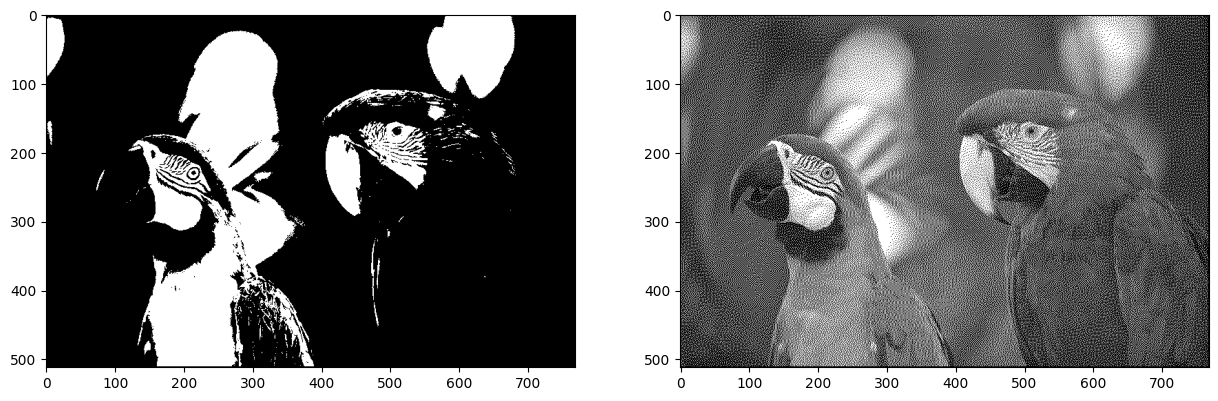

In [447]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(img_int)   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

In [448]:
# Compute average quantization error for dithered image
avg_dith_error = average_error(dithering,img)
avg_img_int_error = average_error(img_int,img)
print("For 3 chnanels avg_img_int_error =",avg_img_int_error, "avg_dith_error =", avg_dith_error)

For 3 chnanels avg_img_int_error = 272.23318604133175 avg_dith_error = 270.56911668703106


In [449]:
float_colors = make_float_n_colors_pallete(4)
print(float_colors, len(float_colors))
img_int, _ =  palette_image(img, float_colors)
dithering = floyd_steinberg_dithering(img, float_colors)

[[0.0, 0.0, 0.0], [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], [0.6666666666666666, 0.6666666666666666, 0.6666666666666666], [1.0, 1.0, 1.0]] 4
float colors =
 [[0.0, 0.0, 0.0], [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], [0.6666666666666666, 0.6666666666666666, 0.6666666666666666], [1.0, 1.0, 1.0]]


(<Axes: >, <matplotlib.image.AxesImage at 0x1d8ed7b5250>)

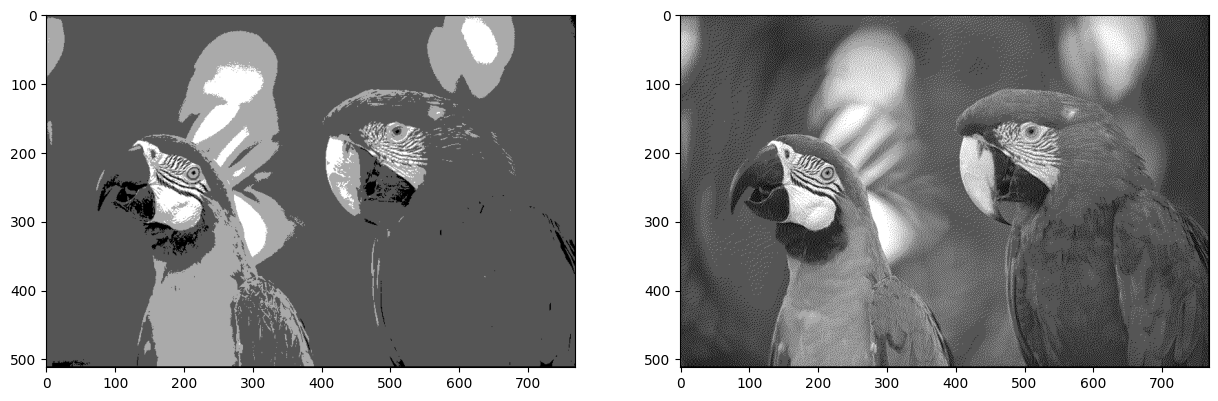

In [450]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(img_int)   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

In [451]:
# Compute average quantization error for dithered image
avg_dith_error = average_error(dithering,img)
avg_img_int_error = average_error(img_int,img)
print("For 3 chnanels avg_img_int_error =",avg_img_int_error, "avg_dith_error =", avg_dith_error)

For 3 chnanels avg_img_int_error = 232.2568849711007 avg_dith_error = 240.02439665088866


In [452]:
float_colors = make_float_n_colors_pallete(8)
print(float_colors, len(float_colors))
img_int, _ =  palette_image(img, float_colors)
dithering = floyd_steinberg_dithering(img, float_colors)

[[0.0, 0.0, 0.0], [0.14285714285714285, 0.14285714285714285, 0.14285714285714285], [0.2857142857142857, 0.2857142857142857, 0.2857142857142857], [0.42857142857142855, 0.42857142857142855, 0.42857142857142855], [0.5714285714285714, 0.5714285714285714, 0.5714285714285714], [0.7142857142857143, 0.7142857142857143, 0.7142857142857143], [0.8571428571428571, 0.8571428571428571, 0.8571428571428571], [1.0, 1.0, 1.0]] 8
float colors =
 [[0.0, 0.0, 0.0], [0.14285714285714285, 0.14285714285714285, 0.14285714285714285], [0.2857142857142857, 0.2857142857142857, 0.2857142857142857], [0.42857142857142855, 0.42857142857142855, 0.42857142857142855], [0.5714285714285714, 0.5714285714285714, 0.5714285714285714], [0.7142857142857143, 0.7142857142857143, 0.7142857142857143], [0.8571428571428571, 0.8571428571428571, 0.8571428571428571], [1.0, 1.0, 1.0]]


(<Axes: >, <matplotlib.image.AxesImage at 0x1d8ebf6f140>)

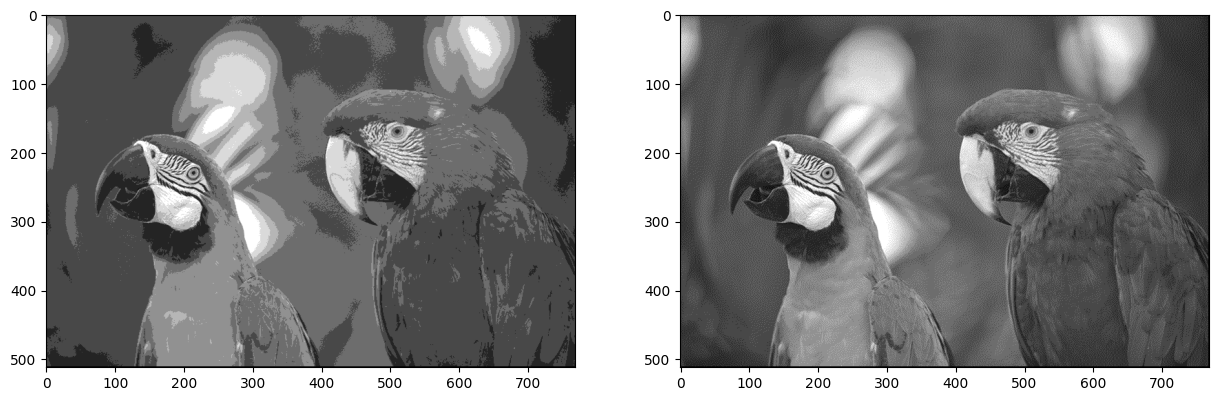

In [453]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(img_int)   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

In [454]:
# Compute average quantization error for dithered image
avg_dith_error = average_error(dithering,img)
avg_img_int_error = average_error(img_int,img)
print("For 3 chnanels avg_img_int_error =",avg_img_int_error, "avg_dith_error =", avg_dith_error)

For 3 chnanels avg_img_int_error = 261.28266434568775 avg_dith_error = 256.24606216686465


### Questions
* Which image has higher quantization error? Optimally quantized or dithered?
  Generally, a dithered image may tends to have a higher quantization error compared to an optimally quantized image, because we add noise to values of pixels. But in our example in 3 examples we have situation  when quantized image have higher quantization error. 
* Which image looks better to you?
  Dithered image looks better. This feature of human vision is explained by adding the value of the points of the picture to the distance
* Can you repeat the same process using only two colours: black and white? Show me :-)
  yes. I make first example with pallete of two colors.

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [455]:
from sklearn.cluster import KMeans

def get_float_kmean_pallete(img,n=16):
    # Reshape the image to be a list of pixels
    pixels = np.reshape(img_rgb, (-1, 3))
    kmeans = KMeans(n_clusters=n).fit(pixels)
    colors = kmeans.cluster_centers_/255
    return colors

float_colors = get_float_kmean_pallete(img)
img_int, _ =  palette_image(img, float_colors)
dithering = floyd_steinberg_dithering(img, float_colors)

float colors =
 [[0.43156869 0.17591278 0.14353613]
 [0.61193096 0.60690192 0.55619398]
 [0.29635785 0.34880494 0.24491685]
 [0.87482359 0.30751181 0.26294211]
 [0.92802176 0.88057293 0.88760785]
 [0.75098656 0.62693304 0.10894685]
 [0.24923398 0.2573996  0.17358968]
 [0.45866507 0.54408687 0.33516767]
 [0.94037726 0.75007042 0.04374312]
 [0.56802747 0.21117813 0.18352865]
 [0.34275706 0.53481991 0.56037139]
 [0.34090285 0.48728934 0.17017786]
 [0.3965363  0.38203334 0.28859865]
 [0.17551099 0.16319996 0.13390595]
 [0.72725488 0.23812971 0.20715518]
 [0.79701634 0.74045982 0.72707671]]


(<Axes: >, <matplotlib.image.AxesImage at 0x1d8ee6d52b0>)

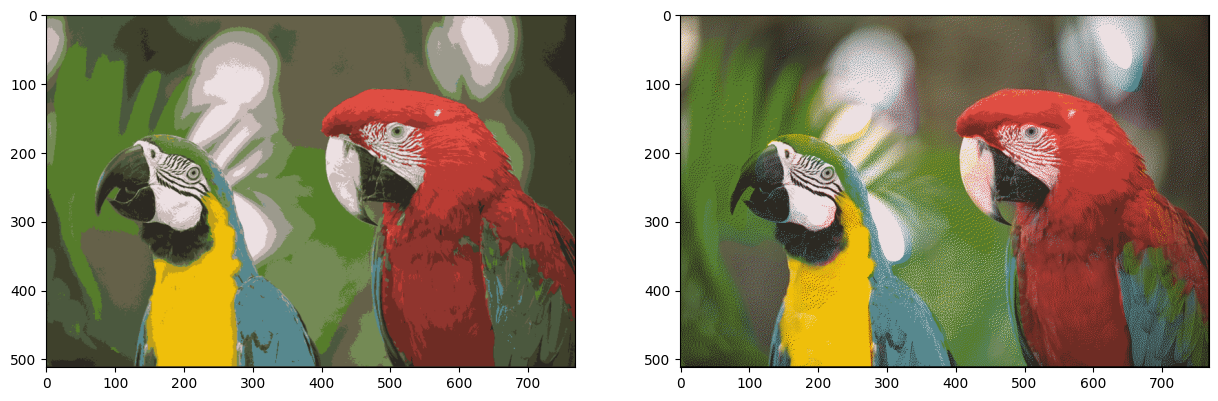

In [456]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(img_int)   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

In [457]:
# Compute average quantization error for dithered image
avg_dith_error = average_error(dithering,img)
avg_img_int_error = average_error(img_int,img)
print("For 3 chnanels avg_img_int_error =",avg_img_int_error, "avg_dith_error =", avg_dith_error)

For 3 chnanels avg_img_int_error = 260.1654725834601 avg_dith_error = 254.7130980193626


In [458]:
float_colors = get_float_kmean_pallete(img,32)
img_int, _ =  palette_image(img, float_colors)
dithering = floyd_steinberg_dithering(img, float_colors)

float colors =
 [[0.24500611 0.22884709 0.18072374]
 [0.75626755 0.70396601 0.60659478]
 [0.87847187 0.69990286 0.03561469]
 [0.5856244  0.20045407 0.17336145]
 [0.37756371 0.35952285 0.27445396]
 [0.90747428 0.85398548 0.86177057]
 [0.38828896 0.51874978 0.23643291]
 [0.32253112 0.51678716 0.546124  ]
 [0.87951872 0.29219954 0.24687221]
 [0.49496567 0.49489362 0.4328314 ]
 [0.89899568 0.77372965 0.72907111]
 [0.32683458 0.4991769  0.13632127]
 [0.24318628 0.37946917 0.37073818]
 [0.78939058 0.76293296 0.79140203]
 [0.39765717 0.16312243 0.1302456 ]
 [0.61798881 0.29973446 0.26663906]
 [0.1604726  0.15132252 0.12506286]
 [0.32085913 0.41205913 0.19640652]
 [0.45182704 0.57281398 0.3138329 ]
 [0.67330955 0.66890235 0.69004421]
 [0.24620491 0.33773556 0.14234845]
 [0.42420669 0.41292432 0.30890499]
 [0.48625343 0.19456113 0.16410208]
 [0.96977441 0.77457677 0.05015943]
 [0.31104588 0.30623676 0.23614218]
 [0.97170399 0.95366433 0.96453968]
 [0.57508429 0.61300306 0.43600483]
 [0.74422776

(<Axes: >, <matplotlib.image.AxesImage at 0x1d8eef8cce0>)

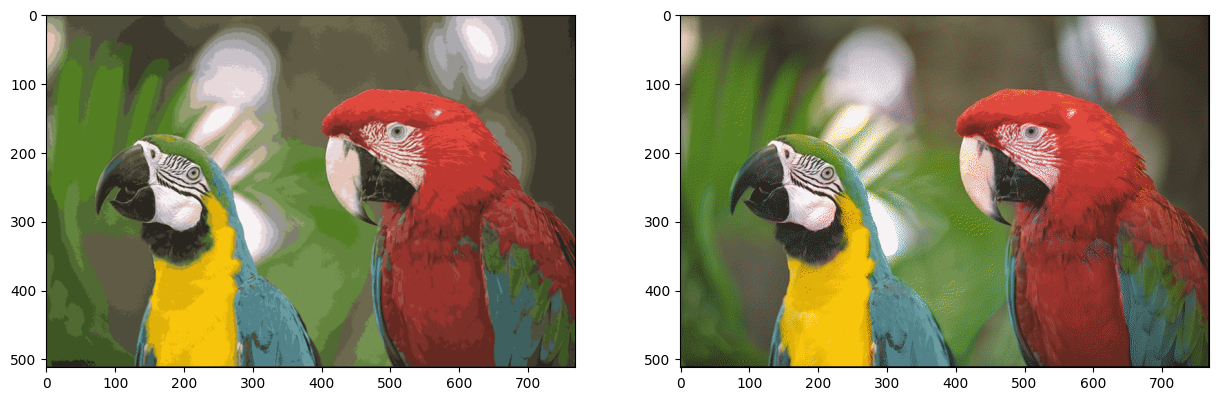

In [459]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(img_int)   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

In [460]:
# Compute average quantization error for dithered image
avg_dith_error = average_error(dithering,img)
avg_img_int_error = average_error(img_int,img)
print("For 3 chnanels avg_img_int_error =",avg_img_int_error, "avg_dith_error =", avg_dith_error)

For 3 chnanels avg_img_int_error = 261.80846885307994 avg_dith_error = 256.33989496142044


In [461]:
float_colors = get_float_kmean_pallete(img,256)
img_int, _ =  palette_image(img, float_colors)
dithering = floyd_steinberg_dithering(img, float_colors)

float colors =
 [[5.81685366e-01 5.82723428e-01 4.59103142e-01]
 [3.88127310e-01 3.58471339e-01 2.66389879e-01]
 [8.57646748e-01 8.06244081e-01 8.05769022e-01]
 [9.41439038e-01 7.51141320e-01 5.37818151e-02]
 [6.26316480e-01 2.84398977e-01 2.53780576e-01]
 [2.37556149e-01 2.13644591e-01 1.67096346e-01]
 [4.40977247e-01 4.76418161e-01 2.75944217e-01]
 [5.97746044e-01 1.80418952e-01 1.53838030e-01]
 [3.45045119e-01 4.71701384e-01 2.00465333e-01]
 [5.68758449e-01 5.68109035e-01 5.68761236e-01]
 [6.78558664e-01 6.53756334e-01 6.25864728e-01]
 [3.11744749e-01 4.68228309e-01 4.83749938e-01]
 [2.87682423e-01 3.75685832e-01 1.90530900e-01]
 [9.66116407e-01 3.74959312e-01 3.15562272e-01]
 [4.29712987e-01 1.76521739e-01 1.46232831e-01]
 [3.94524934e-01 5.55328160e-01 2.67143523e-01]
 [7.72032254e-01 2.56362555e-01 2.20434668e-01]
 [9.93950640e-01 9.90763077e-01 9.92220779e-01]
 [3.28509653e-01 5.09845936e-01 1.27299968e-01]
 [2.89958218e-01 5.33530507e-01 5.81390545e-01]
 [1.28317190e-01 1.06232

(<Axes: >, <matplotlib.image.AxesImage at 0x1d8ef4fc770>)

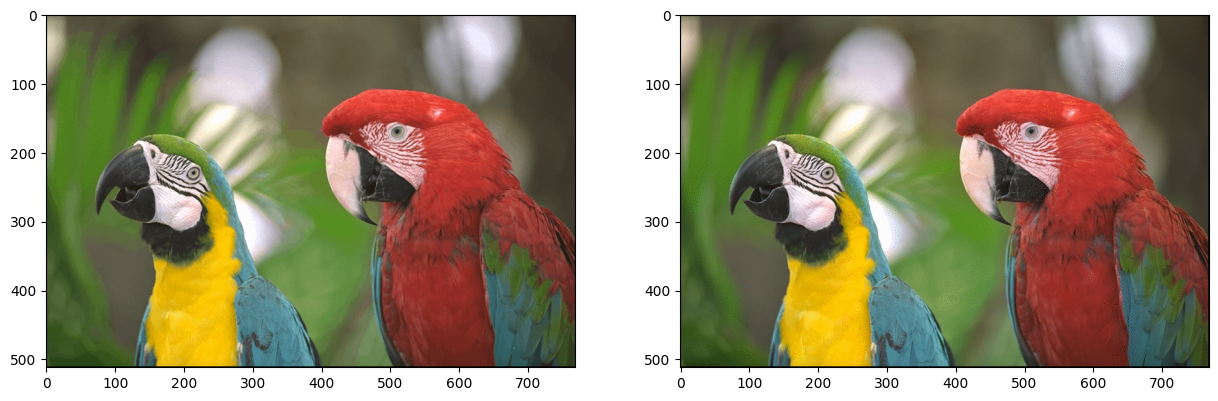

In [462]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(img_int)   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

In [463]:
# Compute average quantization error for dithered image
avg_dith_error = average_error(dithering,img)
avg_img_int_error = average_error(img_int,img)
print("For 3 chnanels avg_img_int_error =",avg_img_int_error, "avg_dith_error =", avg_dith_error)

For 3 chnanels avg_img_int_error = 275.0033273946575 avg_dith_error = 271.841148523936


Apply FS dithering the same way you did before.
* How does the result look like to you? Dithered image is better. But the viewer can distinguish the pixels that create the dithering effect.
* What happens if we use 32 colours? Dithered image is better.
* And what happens if we use 256 colours? Visually pictures looks like the same.